# Imports

In [5]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import pickle
from scipy.spatial import distance
from itertools import product
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d 
from scipy.interpolate import CubicSpline
import random
from deap import base, creator, tools, algorithms
from scipy.optimize import minimize
from scipy.signal import argrelextrema


# Testing on one frame

## Video indices

In [6]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 152, 153, 155, 156, 166, 167, 168, 171, 198]


## Functions:
- get_file_path
- extract_landmarks
- draw_landmarks_on_image

In [7]:
# function to get the file path, according to the label, up_down and video_index
def get_file_path(label, up_down, video_index):

    if label == 'correct':
        image_dir = 'images/correct_seq'
        corr_inc = 'cor'
    elif label == 'incorrect':
        image_dir = 'images/wrong_seq'
        corr_inc = 'inc'
    else:
        print('Label not found')
        exit()

    # Constructing the file pattern using the video index
    file_pattern = f'{corr_inc}_{up_down}_{video_index}_*.jpg'
    file_pattern_path = os.path.join(image_dir, file_pattern)
    # Finding the file that matches the pattern
    matching_files = glob.glob(file_pattern_path)
    # In case there is more than one
    if len(matching_files) > 1:
        print('More than one file found')
        exit()
    # But, there should be only one
    file_path = matching_files[0]
    
    return file_path 

In [8]:
# function to get the landmarks from a frame
def extract_landmarks(this_image_path, model_path='pose_landmarker_heavy.task'):

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        image = mp.Image.create_from_file(this_image_path)

        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to get the landmarks.
        pose_landmarks = None
        if pose_landmarks_list:
            pose_landmarks = pose_landmarks_list[0]

    return pose_landmarks, pose_landmarker_result

In [9]:
# function to display the landmarks on top of the image
def draw_landmarks_on_image(rgb_image, detection_result, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22]):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=2)
        )

        # Draw landmark numbers on the image.
        for i, landmark in enumerate(pose_landmarks):
            if i not in exclude_numbers:  # only number the landmark if it's not in the exclusion list
                cv2.putText(annotated_image, str(i), (int(landmark.x * rgb_image.shape[1]), int(landmark.y * rgb_image.shape[0])),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return annotated_image

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


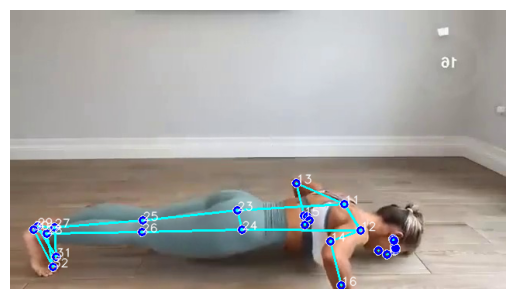

In [10]:
image_path = get_file_path('correct', 'down', video_index_corr[0])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
annotated_image = draw_landmarks_on_image(image, pose_landmarker_result, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22])
plt.imshow(annotated_image)
plt.axis('off')  # Turn off axis
plt.show()



## Functions:
- center_landmarks (on one point, on centroid and on the average of two points)
- draw_landmarks_on_blank_canvas

In [11]:
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose a specific landmark to be the center (e.g., landmark #0)
    center_landmark_index = 24

    # Translate the landmarks so that the center landmark is at (0.5, 0.5)
    centered_landmarks = landmarks_array - landmarks_array[center_landmark_index] + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

# center_landmarks, but with centroid
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Calculate the centroid of the landmarks
    centroid = np.mean(landmarks_array, axis=0)

    # Translate the landmarks so that the centroid is at (0.5, 0.5)
    centered_landmarks = landmarks_array - centroid + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

# instead, center_landmarks with the mean point of 2 landmarks
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose two specific landmarks to be the center (e.g., landmark #0 and #1)
    center_landmark_indices = [23, 24]

    # Calculate the centroid of the landmarks
    centroid = np.mean(landmarks_array[center_landmark_indices], axis=0)

    # Translate the landmarks so that the centroid is at (0.5, 0.5)
    centered_landmarks = landmarks_array - centroid + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks


In [12]:
def draw_landmarks_on_blank_canvas(landmarks, image_size=500, circle_radius=5, line_width=1):
    # Create a blank canvas
    canvas = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255

    # Create landmark list protobuf from landmarks
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in landmarks
    ])

    # Draw landmarks on the canvas
    mp.solutions.drawing_utils.draw_landmarks(
        canvas,
        pose_landmarks_proto,
        mp.solutions.pose.POSE_CONNECTIONS,
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=circle_radius),
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=line_width, circle_radius=2)
    )

    

    return canvas

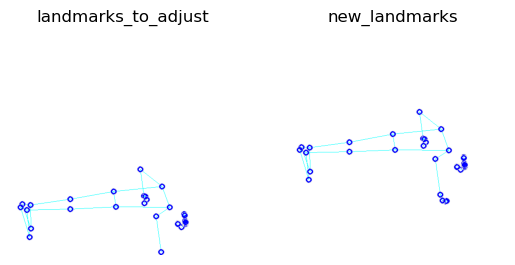

In [13]:
# Display landmarks_adjusted
canvas_adjusted = draw_landmarks_on_blank_canvas(pose_landmarks)
plt.subplot(1, 2, 1)
plt.imshow(canvas_adjusted)
plt.title('landmarks_to_adjust')
plt.axis('off')

new_landmarks = center_landmarks(pose_landmarks)

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(new_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(canvas_new)
plt.title('new_landmarks')
plt.axis('off')

plt.show()

## Function:
- normalize_landmarks

In [14]:
def normalize_landmarks(landmarks_tba, landmarks_rot, connections):
    # Convert landmarks to numpy arrays for easier manipulation
    landmarks_tba_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_tba])
    landmarks_rot_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_rot])

    # Copy landmarks_tba_array to new_landmarks
    new_landmarks = np.copy(landmarks_tba_array)

    # Create an array to keep track of which landmarks have been updated
    updated_landmarks = [False]*len(landmarks_tba)

    # For each connection, adjust the length of the line segment in landmarks_tba to match that in landmarks_rot
    for conn in connections:
        start, end = conn
        # Use updated coordinates for the start point if available
        start_point = new_landmarks[start] if updated_landmarks[start] else landmarks_tba_array[start]

        # Calculate the vector for the line segment in landmarks_tba using original coordinates
        vec_tba = landmarks_tba_array[end] - landmarks_tba_array[start]

        # Calculate the length of the line segment in landmarks_rot
        length_rot = np.linalg.norm(landmarks_rot_array[end] - landmarks_rot_array[start])

        # Compute the direction of the line segment in landmarks_tba
        direction_tba = vec_tba / np.linalg.norm(vec_tba)

        # Compute the end point of the new line segment
        new_landmarks[end] = start_point + direction_tba * length_rot

        # Mark the end landmark as updated
        updated_landmarks[end] = True

    # Convert new_landmarks back to the list of landmark_pb2.NormalizedLandmark
    new_landmarks_pb = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in new_landmarks]

    return new_landmarks_pb


In [15]:
# connections, i.e. order by which we will normalize the landmarks
connections = [
    (23, 24), (23, 11), (24, 12), 
    (11, 13), (12, 14), (13, 15), 
    (14, 16), (15, 17), (16, 18),
    (15, 19), (16, 20), (15, 21),
    (16, 22), (23, 25), (24, 26), 
    (25, 27), (26, 28), (27, 29),
    (28, 30), (27, 31), (28, 32), 
    (11, 0), (12, 0), (0, 1),
    (0, 4), (1, 2), (2, 3),
    (4, 5), (5, 6), (0, 7),
    (0, 8), (2, 7), (5, 8),
    (0, 9), (0, 10)
]


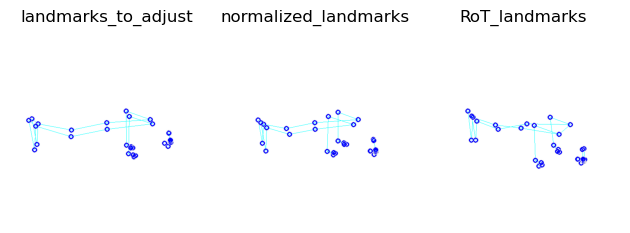

In [16]:
# checking the results of the normalization

# Get the landmarks for the RoT image
RoT_image_path = get_file_path('correct', 'down', video_index_corr[-1])
RoT_pose_landmarks, RoT_pose_landmarker_result = extract_landmarks(RoT_image_path)
RoT_landmarks = center_landmarks(RoT_pose_landmarks)

# Get the landmarks for the image to adjust
to_adjust_image_path = get_file_path('correct', 'down', video_index_corr[-5])
to_adjust_pose_landmarks, to_adjust_pose_landmarker_result = extract_landmarks(to_adjust_image_path)
to_adjust_landmarks = center_landmarks(to_adjust_pose_landmarks)

# Normalize the landmarks
normalized_landmarks = normalize_landmarks(to_adjust_landmarks, RoT_landmarks, connections)

# Display landmarks_to_adjust
canvas_to_adjust = draw_landmarks_on_blank_canvas(to_adjust_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 1)
plt.imshow(canvas_to_adjust)
plt.title('landmarks_to_adjust')
plt.axis('off')

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(normalized_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 2)
plt.imshow(canvas_new)
plt.title('normalized_landmarks')
plt.axis('off')


RoT_landmarks = center_landmarks(RoT_landmarks)
# Display the RoT landmarks
canvas_RoT = draw_landmarks_on_blank_canvas(RoT_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(1, 3, 3)
plt.imshow(canvas_RoT)
plt.title('RoT_landmarks')
plt.axis('off')





plt.tight_layout()
plt.show()


# Now working on all images

## Video indices

In [17]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 153, 155, 156, 166, 167, 168, 171, 198] # took out 152, mediapipe couldn't find landmarks, idky


## Computing average landmarks 
(avg_corr/incorr_up/down)

In [18]:
'''
# Establishing which frame position we want, manually.
up_down = 'up'  # 'up' or 'down'

# Establishing which label we want, manually.
label = 'correct'  # 'correct' or 'incorrect'

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

# Prepare variables to store sum of landmarks and count of images
list_landmarks = []

for video_index in video_indices:
    file_path = get_file_path(label, up_down, video_index)
    # Get landmarks from image
    landmarks = extract_landmarks(file_path)[0]
    # Convert landmarks to numpy array for easier manipulation
    landmarks_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])

    # Add landmarks array to list
    list_landmarks.append(landmarks_array)

# Convert list of landmarks to numpy array
list_landmarks_array = np.array(list_landmarks)

# Calculate average landmarks
avg_landmarks_array = np.mean(list_landmarks_array, axis=0)

# Calculate standard deviation of landmarks
std_landmarks_array = np.std(list_landmarks_array, axis=0)

# Convert average_landmarks back to the list of landmark_pb2.NormalizedLandmark
avg_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in avg_landmarks_array]

'''

"\n# Establishing which frame position we want, manually.\nup_down = 'up'  # 'up' or 'down'\n\n# Establishing which label we want, manually.\nlabel = 'correct'  # 'correct' or 'incorrect'\n\nif label == 'correct':\n    video_indices = video_index_corr\nelif label == 'incorrect':\n    video_indices = video_index_incorr\nelse:\n    print('Label not found')\n    exit()\n\n# Prepare variables to store sum of landmarks and count of images\nlist_landmarks = []\n\nfor video_index in video_indices:\n    file_path = get_file_path(label, up_down, video_index)\n    # Get landmarks from image\n    landmarks = extract_landmarks(file_path)[0]\n    # Convert landmarks to numpy array for easier manipulation\n    landmarks_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])\n\n    # Add landmarks array to list\n    list_landmarks.append(landmarks_array)\n\n# Convert list of landmarks to numpy array\nlist_landmarks_array = np.array(list_landmarks)\n\n# Calculate average la

In [19]:
'''
# Importing the average landmarks with pickle (and std_dev)

# define a filename to save the data
filename = 'avg_landmarks_C_U.pkl'

# open the file in write binary mode
with open(filename, 'wb') as f:
    # dump the avg_landmarks object into the file
    pickle.dump(avg_landmarks, f)
    pickle.dump(std_landmarks_array, f)

'''

"\n# Importing the average landmarks with pickle (and std_dev)\n\n# define a filename to save the data\nfilename = 'avg_landmarks_C_U.pkl'\n\n# open the file in write binary mode\nwith open(filename, 'wb') as f:\n    # dump the avg_landmarks object into the file\n    pickle.dump(avg_landmarks, f)\n    pickle.dump(std_landmarks_array, f)\n\n"

In [20]:
# opening the average landmarks file

#filename = 'avg_landmarks_C_U.pkl'
filename = 'avg_landmarks_C_D.pkl'
#filename = 'avg_landmarks_I_U.pkl'
#filename = 'avg_landmarks_I_D.pkl'

with open(filename, 'rb') as f:
    avg_landmarks = pickle.load(f)
    std_landmarks = pickle.load(f)


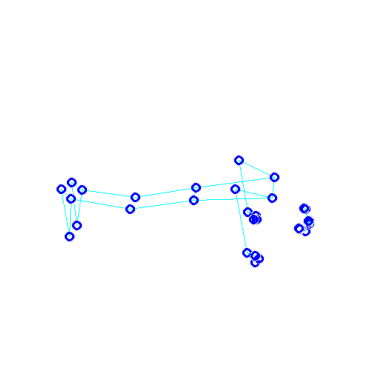

In [21]:
# displaying the average landmarks
avg_landmarks = center_landmarks(avg_landmarks)
canvas_avg = draw_landmarks_on_blank_canvas(avg_landmarks)
plt.imshow(canvas_avg)
plt.axis('off')
plt.show()

## Archiving images' landmarks
for faster run time during hyperparamater optimization

Preselecting the label and pose.

In [22]:
label = 'incorrect' # 'correct' or 'incorrect'

# we pick this one or the one below
#filename = 'avg_landmarks_C_U.pkl' # up
filename = 'avg_landmarks_C_D.pkl' # down

with open(filename, 'rb') as f:
    avg_landmarks = pickle.load(f)
    std_landmarks = pickle.load(f)

if filename == 'avg_landmarks_C_U.pkl':
    up_down = 'up'
elif filename == 'avg_landmarks_C_D.pkl':
    up_down = 'down'
else:
    print('File name not found')
    exit()

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

In [23]:
def save_landmarks(label, up_down, video_indices, avg_landmarks, connections, save_folder='datasets/extracted_landmarks'):
    """Extract and save landmarks from images.

    Arguments:
        label (str): Label of images ('correct' or 'incorrect').
        up_down (str): Pose of images ('up' or 'down').
        video_indices (list): Indices of videos to process.
        avg_landmarks (np.array): Average landmarks.
        connections (list): Connections between landmarks.
        save_folder (str): Directory to save landmarks.
    """
    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        # Get landmarks from image
        landmarks = extract_landmarks(file_path)[0]

        # Center and normalize landmarks
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        
        # Converting landmarks to numpy array for easier manipulation
        landmarks_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])

        # Ensure the directories exist
        directory = os.path.join(save_folder, label, up_down)
        os.makedirs(directory, exist_ok=True)

        # Save landmarks
        save_path = os.path.join(directory, f'{video_index}.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(landmarks_array, f)

In [24]:
'''
save_landmarks(label, up_down, video_indices, avg_landmarks, connections)
'''

'\nsave_landmarks(label, up_down, video_indices, avg_landmarks, connections)\n'

## Euclidean distance classifier

In [25]:
# preparing variables for classification

label = 'incorrect' # 'correct' or 'incorrect'

# we pick this one or the one below
filename = 'avg_landmarks_C_U.pkl' # up
#filename = 'avg_landmarks_C_D.pkl' # down

with open(filename, 'rb') as f:
    avg_landmarks = pickle.load(f)
    std_landmarks = pickle.load(f)

# Convert landmarks to numpy array for easier manipulation
avg_landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in avg_landmarks])

if filename == 'avg_landmarks_C_U.pkl':
    up_down = 'up'
elif filename == 'avg_landmarks_C_D.pkl':
    up_down = 'down'
else:
    print('File name not found')
    exit()

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

In [26]:
# distance classifier
def classify_pushup(new_landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha):

    # instead of only for on landmark_indices, also include a counter
    for counter,i in enumerate(landmark_indices):
        # Calculate Euclidean distance between new and average landmarks
        dist = distance.euclidean([new_landmarks[i][0],new_landmarks[i][1]], [avg_landmarks[i][0], avg_landmarks[i][1]])

        # Get the larger of the std deviations for x and y for this landmark
        max_std = alpha[counter]*max(std_landmarks[i][0], std_landmarks[i][1])

        # If distance exceeds the threshold, classify as incorrect
        if dist > max_std:
            #return f'Incorrect (landmark {i} deviated by {dist})'
            return 'Incorrect'
    # If all landmarks are within the threshold, classify as correct
    return 'Correct'




In [27]:
"""
# Prepare accuracy counter
correct_count = 0


for video_index in video_indices:
    # Get saved landmarks
    landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'
    with open(landmarks_path, 'rb') as f:
        landmarks = pickle.load(f)
    
    # Classify pushup
    #landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head
    landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # no head
    if up_down == 'up':
        alpha = 10.0  # Std coefficient
    elif up_down == 'down':
        alpha = 3.0  # Std coefficient
    else:
        print('Up/down not found')
        exit()

    # Several alphas that we found through min max optimization (evolutionary algorithm, further down the notebook)



    # UP 90% / 57%
    alpha = [2, 5, 2, 3, 2.9594074807972257, 3, 2, 4, 4, 4, 1, 4]
    # UP 98% / 46%
    alpha = [2, 5, 4, 4, 2, 4, 1, 3, 3, 4, 4, 2]
    # UP 94% / 73%
    alpha = [2.082813972116944, 4, 4.671523466121219, 3, 3, 5, 2.4108312584160725, 5, 1.1446358102274812, 2.413145093976241, 1.037151756244703, 3.680295094225021]
    # UP 100% / 57% !!!
    alpha = [2.115142580035192, 4, 2, 3.7729897699516117, 5, 4.710578789980281, 2, 3, 3, 4.993068313877909, 2, 2]
    # UP 96% / 48% !!!
    alpha = [2.7524237159600378, 3.228970987998083, 4, 5, 2, 3.503512288035695, 1.2311421758590684, 3, 3.97840902405104, 3, 1.037151756244703, 5]
    # DOWN 88% / 61% !!!
    alpha = [5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4]

    # Apply classification function
    
    classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices,alpha)
    
    # Accuracy
    if classification == 'Correct':
        correct_count += 1


# Print accuracy
print(f'Accuracy: {correct_count/len(video_indices)*100:.2f}% for {label} {up_down} pushups, alpha={alpha}')
"""

"\n# Prepare accuracy counter\ncorrect_count = 0\n\n\nfor video_index in video_indices:\n    # Get saved landmarks\n    landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'\n    with open(landmarks_path, 'rb') as f:\n        landmarks = pickle.load(f)\n    \n    # Classify pushup\n    #landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head\n    landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # no head\n    if up_down == 'up':\n        alpha = 10.0  # Std coefficient\n    elif up_down == 'down':\n        alpha = 3.0  # Std coefficient\n    else:\n        print('Up/down not found')\n        exit()\n\n    # Several alphas that we found through min max optimization (evolutionary algorithm, further down the notebook)\n\n\n\n    # UP 90% / 57%\n    alpha = [2, 5, 2, 3, 2.9594074807972257, 3, 2, 4, 4, 4, 1, 4]\n    # UP 98% / 46%\n    alpha = [2, 5, 4, 4, 2, 4, 1, 3, 3, 4, 4, 2]\n    # UP 94% / 73%\n    alpha = [

In [28]:
"""
landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # no head

# test image
image_path =  'images_with_landmarks/test/up/correct_seq/3_cor.png'
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)
centered_landmarks = center_landmarks(pose_landmarks)
avg_NL = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in avg_landmarks]
normalized_landmarks = normalize_landmarks(centered_landmarks, avg_NL, connections)
normalized_np = np.array([[landmark.x, landmark.y, landmark.z] for landmark in normalized_landmarks])
print(classify_pushup(normalized_np, avg_landmarks, std_landmarks, landmark_indices, alpha))

# display the image
canvas = draw_landmarks_on_image(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), pose_landmarker_result)
plt.imshow(canvas)
plt.axis('off')
plt.show()

"""

"\nlandmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # no head\n\n# test image\nimage_path =  'images_with_landmarks/test/up/correct_seq/3_cor.png'\npose_landmarks, pose_landmarker_result = extract_landmarks(image_path)\ncentered_landmarks = center_landmarks(pose_landmarks)\navg_NL = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in avg_landmarks]\nnormalized_landmarks = normalize_landmarks(centered_landmarks, avg_NL, connections)\nnormalized_np = np.array([[landmark.x, landmark.y, landmark.z] for landmark in normalized_landmarks])\nprint(classify_pushup(normalized_np, avg_landmarks, std_landmarks, landmark_indices, alpha))\n\n# display the image\ncanvas = draw_landmarks_on_image(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), pose_landmarker_result)\nplt.imshow(canvas)\nplt.axis('off')\nplt.show()\n\n"

In [29]:
"""
# Define possible alpha values and initialize variables
alpha_values = np.arange(1.0, 3.0, 0.01)
best_alpha = None
best_accuracy = 0


# Loop over all possible alpha values
for alpha in alpha_values:
    
    # Prepare accuracy counter
    correct_count = 0

    for video_index in video_indices:
        # Get saved landmarks
        landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'
        with open(landmarks_path, 'rb') as f:
            landmarks = pickle.load(f)
        
        # Classify pushup
        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # Upper & Lower Body
        
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, np.zeros(13) + alpha)

        if classification == 'Correct':
            correct_count += 1

    # Calculate and print accuracy for this alpha value
    accuracy = correct_count / len(video_indices)
    #print(f'Alpha: {alpha:.1f}, Accuracy: {accuracy * 100:.2f}%', end='\r')

    # If this accuracy is the best so far, store alpha and accuracy
    if accuracy > best_accuracy:
        best_alpha = alpha
        best_accuracy = accuracy
    if accuracy == 1.0:
        best_alpha = alpha
        best_accuracy = accuracy
        break

# Print best alpha value and corresponding accuracy
print(f'Best alpha: {best_alpha:.2f}, Best accuracy: {best_accuracy * 100:.2f}%')
"""

"\n# Define possible alpha values and initialize variables\nalpha_values = np.arange(1.0, 3.0, 0.01)\nbest_alpha = None\nbest_accuracy = 0\n\n\n# Loop over all possible alpha values\nfor alpha in alpha_values:\n    \n    # Prepare accuracy counter\n    correct_count = 0\n\n    for video_index in video_indices:\n        # Get saved landmarks\n        landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'\n        with open(landmarks_path, 'rb') as f:\n            landmarks = pickle.load(f)\n        \n        # Classify pushup\n        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # Upper & Lower Body\n        \n        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, np.zeros(13) + alpha)\n\n        if classification == 'Correct':\n            correct_count += 1\n\n    # Calculate and print accuracy for this alpha value\n    accuracy = correct_count / len(video_indices)\n    #print(f'Alpha: {alp

Plain grid search (too RAM heavy)

In [30]:
"""
# Define possible alpha values
alpha_values = np.arange(1.0, 5.0, 1.0)

# Generate all combinations of alpha values for two landmarks
alpha_combinations = list(product(alpha_values, repeat=len(landmark_indices)))

best_alpha_combination = None
best_accuracy = 0

# Loop over all combinations of alpha values
for alpha_combination in alpha_combinations:

    # Prepare accuracy counter
    correct_count = 0

    for video_index in video_indices:
        file_path = get_file_path(label, up_down, video_index)
        landmarks = extract_landmarks(file_path)[0]
        landmarks = center_landmarks(landmarks)
        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)
        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha_combination)

        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)

    
    # If this accuracy is the best so far, store alpha and accuracy
    if accuracy > best_accuracy:
        best_alpha_combination = alpha_combination
        best_accuracy = accuracy
        
    print(f'Current alpha: {alpha}, current best alpha: {best_alpha_combination}, Current best accuracy: {best_accuracy * 100:.2f}%, iteration {alpha_combinations.index(alpha_combination)} of {len(alpha_combinations)}', end='\r')


# Print best alpha value and corresponding accuracy
print(f'Best alpha: {best_alpha_combination}, Best accuracy: {best_accuracy * 100:.2f}%')

"""

"\n# Define possible alpha values\nalpha_values = np.arange(1.0, 5.0, 1.0)\n\n# Generate all combinations of alpha values for two landmarks\nalpha_combinations = list(product(alpha_values, repeat=len(landmark_indices)))\n\nbest_alpha_combination = None\nbest_accuracy = 0\n\n# Loop over all combinations of alpha values\nfor alpha_combination in alpha_combinations:\n\n    # Prepare accuracy counter\n    correct_count = 0\n\n    for video_index in video_indices:\n        file_path = get_file_path(label, up_down, video_index)\n        landmarks = extract_landmarks(file_path)[0]\n        landmarks = center_landmarks(landmarks)\n        landmarks = normalize_landmarks(landmarks, avg_landmarks, connections)\n        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]\n        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha_combination)\n\n        if classification == 'Correct':\n            correct_count += 1\n\n    # Calculate a

## Optimizing: evolutionary algorithm

In [31]:
# preparing variables for classification

label = 'correct' # 'correct' or 'incorrect'

# we pick this one or the one below
filename = 'avg_landmarks_C_U.pkl' # up
#filename = 'avg_landmarks_C_D.pkl' # down

with open(filename, 'rb') as f:
    avg_landmarks = pickle.load(f)
    std_landmarks = pickle.load(f)

# Convert landmarks to numpy array for easier manipulation
avg_landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in avg_landmarks])

if filename == 'avg_landmarks_C_U.pkl':
    up_down = 'up'
elif filename == 'avg_landmarks_C_D.pkl':
    up_down = 'down'
else:
    print('File name not found')
    exit()

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

In [32]:
"""
landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head
population_size = 100 # 50
n_generations = 50 # 40
alpha_min = 1.0
alpha_max = 50.0

# create classes for fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax, n=len(landmark_indices))

toolbox = base.Toolbox()

# define alpha values for each individual
toolbox.register("attr_alpha", random.uniform, alpha_min, alpha_max)  # previously 1.0, 5.0)

# define the individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



# define the fitness function
def evalPushupAccuracy(individual):
    correct_count = 0

    for video_index in video_indices:
        landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'
        with open(landmarks_path, 'rb') as f:
            landmarks = pickle.load(f)
        #landmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head
        landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # no head
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, individual)

        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)
    
    return (accuracy,)

# set up the evaluation, selection, crossover, and mutation operators
toolbox.register("evaluate", evalPushupAccuracy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=alpha_min, up=alpha_max, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# setting up statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

def main():
    pop = toolbox.population(n=population_size)  # you may adjust the population size as needed
    hof = tools.HallOfFame(1)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, stats=stats, halloffame=hof, verbose=False)  # adjust parameters as needed

    return pop, logbook, hof

if __name__ == "__main__":
    population, log, hof = main()
    print(f'Best accuracy: {hof[0].fitness.values[0] * 100:.2f}%, Best individual: {hof[0]}')

"""

'\nlandmark_indices=[0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # U&L body, head\npopulation_size = 100 # 50\nn_generations = 50 # 40\nalpha_min = 1.0\nalpha_max = 50.0\n\n# create classes for fitness and individual\ncreator.create("FitnessMax", base.Fitness, weights=(1.0,))\ncreator.create("Individual", list, fitness=creator.FitnessMax, n=len(landmark_indices))\n\ntoolbox = base.Toolbox()\n\n# define alpha values for each individual\ntoolbox.register("attr_alpha", random.uniform, alpha_min, alpha_max)  # previously 1.0, 5.0)\n\n# define the individual and population\ntoolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))\ntoolbox.register("population", tools.initRepeat, list, toolbox.individual)\n\n\n\n# define the fitness function\ndef evalPushupAccuracy(individual):\n    correct_count = 0\n\n    for video_index in video_indices:\n        landmarks_path = f\'datasets/extracted_landmarks/{label}/{up_down}/{video_index}

Solving $\min \max accuracy(\alpha)$

In [33]:
"""
alpha_min = 0.0
alpha_max = 4.0
population_size = 100
landmark_indices = landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # Upper & Lower Body
n_generations = 2000
mutation_rate = 0.05


# Create classes for fitness and individual
# Note the use of two weights, one for each objective.
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Define alpha values for each individual (13 landmarks)
toolbox.register("attr_alpha", random.uniform, alpha_min, alpha_max)

# Define the individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalPushupAccuracy(individual):
    correct_count = 0
    for video_index in video_indices:
        landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'
        with open(landmarks_path, 'rb') as f:
            landmarks = pickle.load(f)
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, individual)
        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)

    # The sum of the alpha vector is the second objective
    alpha_sum = sum(individual)

    return accuracy, alpha_sum  # the FitnessMulti object will try to maximize the first and minimize the second

# set up the evaluation, selection, crossover, and mutation operators
toolbox.register("evaluate", evalPushupAccuracy)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=alpha_min, up=alpha_max, indpb=0.1)
toolbox.register("select", tools.selNSGA2)  # we use the NSGA-II algorithm

# setting up statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

def main():
    pop = toolbox.population(n=population_size)
    hof = tools.ParetoFront()  # we use a Pareto front instead of a Hall of Fame
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=mutation_rate
    , ngen=n_generations, stats=stats, halloffame=hof, verbose=False)

    return pop, logbook, hof

if __name__ == "__main__":
    population, log, hof = main()
    # Print all solutions on the Pareto front
    for individual in hof:
        print(f"Accuracy: {individual.fitness.values[0] * 100:.2f}%, Alpha sum: {individual.fitness.values[1]:.2f}, Alpha vector: {individual}")
    # Print the best solution on the Pareto front
    print(f"Best accuracy: {hof[0].fitness.values[0] * 100:.2f}%, Best alpha sum: {hof[0].fitness.values[1]:.2f}, Best alpha vector: {hof[0]}")
"""

'\nalpha_min = 0.0\nalpha_max = 4.0\npopulation_size = 100\nlandmark_indices = landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # Upper & Lower Body\nn_generations = 2000\nmutation_rate = 0.05\n\n\n# Create classes for fitness and individual\n# Note the use of two weights, one for each objective.\ncreator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))\ncreator.create("Individual", list, fitness=creator.FitnessMulti)\n\ntoolbox = base.Toolbox()\n\n# Define alpha values for each individual (13 landmarks)\ntoolbox.register("attr_alpha", random.uniform, alpha_min, alpha_max)\n\n# Define the individual and population\ntoolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_alpha, n=len(landmark_indices))\ntoolbox.register("population", tools.initRepeat, list, toolbox.individual)\n\ndef evalPushupAccuracy(individual):\n    correct_count = 0\n    for video_index in video_indices:\n        landmarks_path = f\'datasets/extracted_landmarks/{l

In [34]:
# implementing nelder mead for optimization


# Define the objective function
def neg_accuracy_and_alpha_norm(alpha):
    correct_count = 0
    for video_index in video_indices:
        landmarks_path = f'datasets/extracted_landmarks/{label}/{up_down}/{video_index}.pkl'
        with open(landmarks_path, 'rb') as f:
            landmarks = pickle.load(f)
        classification = classify_pushup(landmarks, avg_landmarks, std_landmarks, landmark_indices, alpha)
        if classification == 'Correct':
            correct_count += 1

    # Calculate accuracy for this alpha value
    accuracy = correct_count / len(video_indices)

    # Norm of alpha vector
    alpha_norm = np.linalg.norm(alpha)

    return -accuracy + 1/(13*3) * alpha_norm 

"""# Define the initial guess
x0 = np.zeros(len(landmark_indices)) + 1

# Define the bounds
alpha_min = 0.0
alpha_max = 5.0
bounds = [(alpha_min, alpha_max)] * len(landmark_indices)

scipy_result = minimize(neg_accuracy_and_alpha_norm, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True}, bounds=bounds)
"""

"# Define the initial guess\nx0 = np.zeros(len(landmark_indices)) + 1\n\n# Define the bounds\nalpha_min = 0.0\nalpha_max = 5.0\nbounds = [(alpha_min, alpha_max)] * len(landmark_indices)\n\nscipy_result = minimize(neg_accuracy_and_alpha_norm, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True}, bounds=bounds)\n"

In [35]:
"""
k = 13*3
print(scipy_result)
# norm of alpha vector
norm = np.linalg.norm(scipy_result.x)
print(norm)
# accuracy
print(norm/k - scipy_result.fun)"""

'\nk = 13*3\nprint(scipy_result)\n# norm of alpha vector\nnorm = np.linalg.norm(scipy_result.x)\nprint(norm)\n# accuracy\nprint(norm/k - scipy_result.fun)'

# Ensemble

## CNN

/home/caria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caria/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


correct_seq


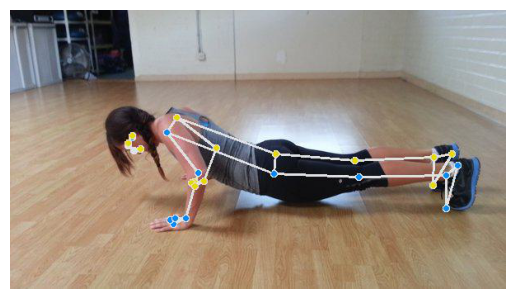

In [36]:
from L_pipeline_cnn import predict_down, predict_up

image_path = 'images_with_landmarks/train/up/correct_seq/cor_up_1_16.jpg' # correct 
image_path = 'images_with_landmarks/test/down/wrong_seq/6_inc.jpg' # wrong
#image_path = 'images_with_landmarks/test/down/correct_seq/2_cor.jpg' # wrong

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# convert frame to a numpy array
mp_frame = np.array(image)
# convert frame to a MediaPipe Image object
mp_frame = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_frame)

# outputs 'correct_seq' or 'wrong_seq'
result = predict_up(mp_frame)
print(result)

# display the image
plt.imshow(image)
plt.axis('off')
plt.show()

## Angles

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import glob
import PIL 

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def calculate_angle_2D(m, p1, p2, p3):
    
    point1 = (m[p1][0],m[p1][1])
    point2 = (m[p2][0],m[p2][1])
    point3 = (m[p3][0],m[p3][1])

    # Calculate the vectors from point2 to point1 and point2 to point3
    vector_21 = [point1[0] - point2[0], point1[1] - point2[1]]
    vector_23 = [point3[0] - point2[0], point3[1] - point2[1]]

    # Calculate the dot product of the vectors
    dot_product = vector_21[0]*vector_23[0] + vector_21[1]*vector_23[1]

    # Calculate the magnitudes of the vectors
    magnitude_21 = math.sqrt(vector_21[0]**2 + vector_21[1]**2)
    magnitude_23 = math.sqrt(vector_23[0]**2 + vector_23[1]**2)

    # Use the dot product to calculate the angle
    angle = math.acos(dot_product / (magnitude_21 * magnitude_23))

    # Convert the angle from radians to degrees
    angle = math.degrees(angle)

    return angle

def angle_analysis(image, pose):

    model_path = 'pose_landmarker_heavy.task'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:

        # Load the input image from an image file.
        # image = mp.Image.create_from_file(file_path)
    
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to visualize.
        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]

            # Draw the pose landmarks.
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])

        m = np.zeros((33,3))

        for i in range(33):
          pose_landmark = pose_landmarks_list[0][i]
          m[i][0] = float(pose_landmark.x)
          m[i][1] = float(pose_landmark.y)
          m[i][2] = float(pose_landmark.z)

        check = 1

        if(pose=='up'):
          angles=np.zeros(8)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          angles[4] = calculate_angle_2D(m, 11, 13, 15)
          angles[5] = calculate_angle_2D(m, 12, 14, 16)
          angles[6] = calculate_angle_2D(m, 23, 11, 13)
          angles[7] = calculate_angle_2D(m, 24, 12, 14)
          threshold = np.array([20,30,20,30,20,20,20,20])
          mean = np.array([170,165,170,165,170,170,55,55])

          for i in range(len(angles)):
            if(abs(mean[i] - angles[i])>threshold[i]):
              check = 0
              break
          
        elif(pose=='down'):
          angles=np.zeros(4)
          angles[0] = calculate_angle_2D(m, 11, 23, 25)
          angles[1] = calculate_angle_2D(m, 23, 25, 27)
          angles[2] = calculate_angle_2D(m, 12, 24, 26)
          angles[3] = calculate_angle_2D(m, 24, 26, 28)
          threshold = np.array([20,30,20,30])
          mean = np.array([170,160,170,160])

          for i in range(len(angles)):
            if(abs(mean[i] - angles[i])>threshold[i]):
              check = 0
              break

        else:
           print("pose not found")

    return check

# outputs 1 if the pose is correct, 0 if it is incorrect


## Distances

### Previous function(s) that had to be modified
to have them receive frames instead of frame paths

In [38]:
# function to get the landmarks from a frame
def extract_landmarks_image(image, model_path='pose_landmarker_heavy.task'):
    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to get the landmarks.
        pose_landmarks = None
        if pose_landmarks_list:
            pose_landmarks = pose_landmarks_list[0]

    return pose_landmarks, pose_landmarker_result


### Actual classifier
(up and down)

Correct


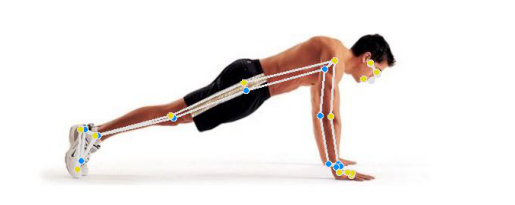

In [39]:
# Classifier based on euclidean distance (one for up pose and one for down pose)
def distances_classifier(image,up_down):

    # UP 96% / 48% !!!
    alpha_up1 = [2.7524237159600378, 3.228970987998083, 4, 5, 2, 3.503512288035695, 1.2311421758590684, 3, 3.97840902405104, 3, 1.037151756244703, 5]
    # UP 100% / 57% !!!
    alpha_up2 = [2.115142580035192, 4, 2, 3.7729897699516117, 5, 4.710578789980281, 2, 3, 3, 4.993068313877909, 2, 2]
    # DOWN 88% / 61%
    alpha_down = [5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4]

    # preparing variables for classification
    if up_down == 'up':
        filename = 'avg_landmarks_C_U.pkl'
        alpha = alpha_up2 # currently using alpha_up_2
    elif up_down == 'down':
        filename = 'avg_landmarks_C_D.pkl'
        alpha = alpha_down
    else:
        print('File name not found')
        exit()

    with open(filename, 'rb') as f:
        avg_landmarks = pickle.load(f)
        std_landmarks = pickle.load(f)

    # Convert landmarks to numpy array for easier manipulation
    avg_landmarks = np.array([[landmark.x, landmark.y, landmark.z] for landmark in avg_landmarks])

    landmark_indices=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28] # Upper & Lower Body

    pose_landmarks, pose_landmarker_result = extract_landmarks_image(image)
    pose_landmarks = [landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks]
    centered_landmarks = center_landmarks(pose_landmarks)
    avg_NL = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in avg_landmarks]
    normalized_landmarks = normalize_landmarks(centered_landmarks, avg_NL, connections)
    normalized_np = np.array([[landmark.x, landmark.y, landmark.z] for landmark in normalized_landmarks])
    return classify_pushup(normalized_np, avg_landmarks, std_landmarks, landmark_indices, alpha)

# test image

image_path =  'images_with_landmarks/test/up/correct_seq/1_cor.jpg'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# convert frame to a numpy array
mp_frame = np.array(image)
# convert frame to a MediaPipe Image object
mp_frame = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_frame)
print(distances_classifier(mp_frame, 'up'))

plt.imshow(image)
plt.axis('off')
plt.show()

## Video

### Watch_video_frame function

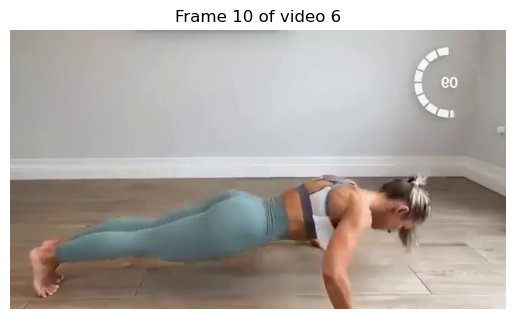

In [40]:
video_index = 5  # replace with your video index
frame_index = 10  # replace with your frame index

def watch_video_frame(video_index, frame_index):
    video_path = f'datasets/data_corr_incorr/Correct sequence/Copy of push up {video_index}.mp4'  # adjust as needed

    # create a VideoCapture object
    video = cv2.VideoCapture(video_path)

    # check if video opened successfully
    if not video.isOpened():
        print(f"Error opening video file {video_path}")
        return

    # set the video position to the desired frame
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # read the frame at the current position
    ret, frame = video.read()

    if ret:
        # convert the image from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # display the image using plt
        plt.imshow(frame)
        plt.title(f'Frame {frame_index} of video {video_index}')
        plt.axis('off')
        plt.show()

    else:
        print(f"Could not read frame {frame_index} from video {video_index}")

    # release the video capture object
    video.release()

# Usage:
watch_video_frame(video_index_corr[video_index], frame_index)  

### Auxiliary functions
- Smoothing functions (to smoothen the shoulder-hand distance)
- UP and DOWN frames get function

In [41]:
def smooth_cubic_spline(d_shoulder_hand_list, div_factor=5):
    # creating a list of the original indices
    x = list(range(len(d_shoulder_hand_list)))

    # creating a cubic spline interpolation
    cs = CubicSpline(x, d_shoulder_hand_list)
    cs = CubicSpline(x, d_shoulder_hand_list, bc_type=((1, 0.0), (1, 0.0)))


    # creating a more dilute list of 'new' x-values with higher resolution
    xnew = np.linspace(min(x), max(x), len(x) // div_factor)

    # creating a list of the smoothed values using the new x-values
    d_shoulder_hand_list_smooth = cs(xnew)
    
    return xnew, d_shoulder_hand_list_smooth

# smoothing with moving average
def smooth_moving_average(d_shoulder_hand_list, window_size):
    pad_size = window_size // 2
    # create a padded version of the input list
    padded_list = [d_shoulder_hand_list[0]] * pad_size + d_shoulder_hand_list + [d_shoulder_hand_list[-1]] * pad_size
    # calculate the moving average
    d_shoulder_hand_list_smooth = np.convolve(padded_list, np.ones(window_size)/window_size, mode='valid')
    return d_shoulder_hand_list_smooth

# obtaining the frames of the UP and DOWN positions
def get_up_down_frames(d_shoulder_hand_list_smooth):
    # Getting the indices of local minima and maxima
    minima = argrelextrema(np.array(d_shoulder_hand_list_smooth), np.less)[0]
    maxima = argrelextrema(np.array(d_shoulder_hand_list_smooth), np.greater)[0]

    # The DOWN position is the global minimum
    down = np.argmin(d_shoulder_hand_list_smooth)

    # The first UP position is the highest maxima to the left of DOWN
    up1 = maxima[maxima < down]
    if up1.size > 0:
        up1 = up1[np.argmax(d_shoulder_hand_list_smooth[up1])]
    else:
        up1 = 0

    # The last UP position is the highest maxima to the right of DOWN
    up2 = maxima[maxima > down]
    if up2.size > 0:
        up2 = up2[np.argmax(d_shoulder_hand_list_smooth[up2])]
    else:
        up2 = len(d_shoulder_hand_list_smooth) - 1

    return up1, down, up2


### Main loop
- UP/DOWN detection
- Ensemble

In [42]:
video_index_corr[-10:]

[165, 173, 174, 175, 177, 178, 186, 187, 188, 197]

In [43]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 83, 85, 100, 101, 102, 113, 114, 115, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 186, 187, 188, 197] 
# no 176, 80,116, 177,  178, after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 152, 153, 155, 156, 166, 167, 168, 171, 198]

In [44]:
label = 'correct' # 'correct' or 'incorrect

# list of video indices
if label == 'correct':
    video_indices = video_index_corr
    path_part = 'Correct sequence'
elif label == 'incorrect':
    video_indices = video_index_incorr
    path_part = 'Wrong sequence'
else:
    print('Label not found')
    exit()

video_indices = video_indices
# prepare variables for classification results
cnn_results = [] # CNN
angle_results = [] # angle analysis
distance_results = [] # euclidean distance
for video_index in video_indices:
    # construct video path from index
    video_path = f'datasets/data_corr_incorr/{path_part}/Copy of push up {video_index}.mp4'  # adjust as needed

    # create a VideoCapture object
    video = cv2.VideoCapture(video_path)

    # check if video opened successfully
    if not video.isOpened():
        print(f"Error opening video file {video_path}")
        continue

    # process video frame by frame
    frame_index = 0
    d_shoulder_hand_list = [] # initializing the shoulder-hand distance list
    while video.isOpened():
        # read next frame (success, image frame)
        ret, frame = video.read()
        
        if ret:
            # frame successfully read
            print(f"Processing frame {frame_index} of video {video_index}", end='\r')
            
            # convert the image from BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # convert frame to a numpy array
            mp_frame = np.array(rgb_frame)
            # convert frame to a MediaPipe Image object
            mp_frame = mp.Image(image_format = mp.ImageFormat.SRGB, data = frame)
            # extracting the frame's landmarks
            landmarks = extract_landmarks_image(mp_frame)[0]
            
            # checking the distance between the right shoulder and the right hand
            d_shoulder_hand = distance.euclidean([landmarks[12].x,landmarks[12].y], [landmarks[16].x,landmarks[16].y])

            # appending the distance to the list
            d_shoulder_hand_list.append(d_shoulder_hand)


            frame_index += 1
        else:
            # no more frames available, break the loop
            break
        
        # end of current frame
    
    # end of current video
    
    # smoothing the shoulder-hand distance list
    d_shoulder_hand_list_smooth = smooth_moving_average(d_shoulder_hand_list, window_size=len(d_shoulder_hand_list)//4)

    # now we find which frames were the UP and DOWN position frames (UP -> DOWN -> UP)
    up1, down, up2 = get_up_down_frames(d_shoulder_hand_list_smooth)

    # assigning the corresponding frames to the corresponding positions
    video.set(1, up1)
    ret, frame_up1 = video.read()
    frame_up1 = cv2.cvtColor(frame_up1, cv2.COLOR_BGR2RGB)

    video.set(1, down)
    ret, frame_down = video.read()
    frame_down = cv2.cvtColor(frame_down, cv2.COLOR_BGR2RGB)

    video.set(1, up2)
    ret, frame_up2 = video.read()
    frame_up2 = cv2.cvtColor(frame_up2, cv2.COLOR_BGR2RGB)




    # classifying each frame, with the three methods

    # CNN
    # convert frame to a numpy array
    mp_up1 = np.array(frame_up1)
    mp_down = np.array(frame_down)
    mp_up2 = np.array(frame_up2)
    # convert frame to a MediaPipe Image object
    mp_frame_up1 = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_up1)
    mp_frame_down = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_down)
    mp_frame_up2 = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_up2)
    # outputs 'correct_seq' or 'wrong_seq'
    cnn_results.append([predict_up(mp_frame_up1), predict_down(mp_frame_down), predict_up(mp_frame_up2)])
    
    # angle analysis
    # image already in mp format
    # outputs 1 if the pose is correct, 0 if it is incorrect
    angle_results.append([angle_analysis(mp_frame_up1, 'up'), angle_analysis(mp_frame_down, 'down'), angle_analysis(mp_frame_up2, 'up')])

    # euclidean distance
    # image also already in mp format    
    # outputs 'Correct' or 'Incorrect'
    distance_results.append([distances_classifier(mp_frame_up1, 'up'), distances_classifier(mp_frame_down, 'down'), distances_classifier(mp_frame_up2, 'up')])

    # release the video capture object
    video.release()

# close any open windows
cv2.destroyAllWindows()



KeyboardInterrupt: 

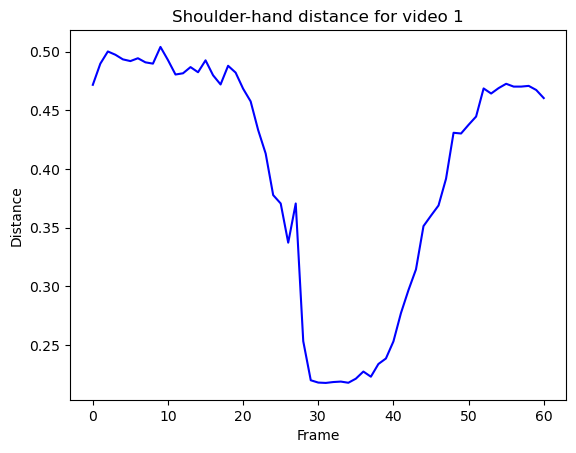

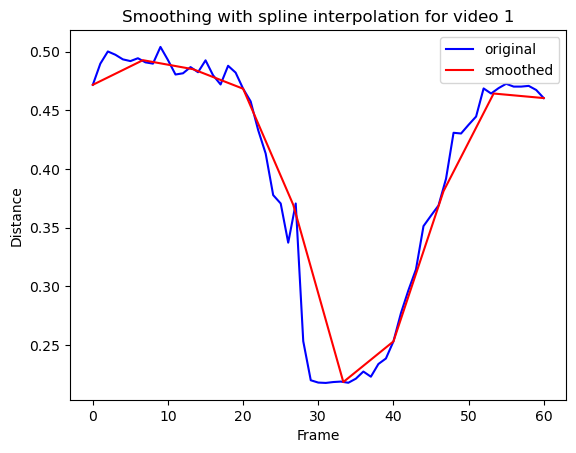

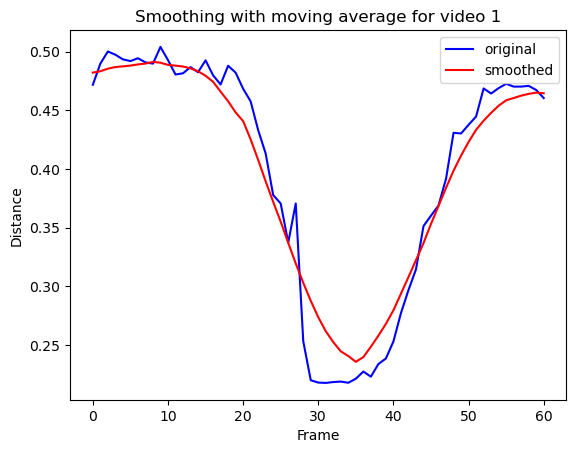

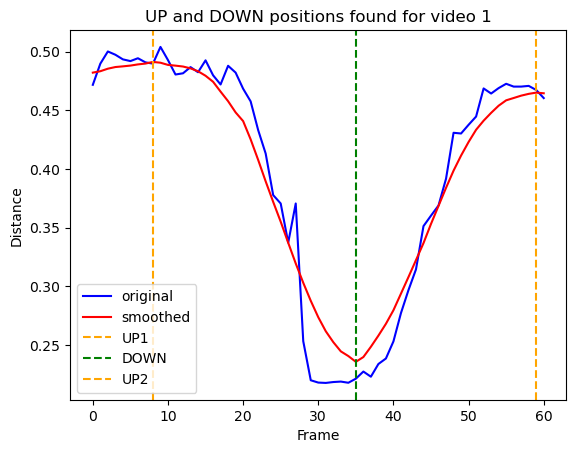

In [ ]:
# plotting the shoulder-hand distance
plt.plot(d_shoulder_hand_list, color='blue',label='shoulder-hand distance')

plt.title(f'Shoulder-hand distance for video {video_index}')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.show()



# plotting the smoothed shoulder-hand distance on top of the original, with different colours
plt.plot(d_shoulder_hand_list, color='blue',label='original')
# smoothing with spline interpolation
x_smooth, spline_smooth = smooth_cubic_spline(d_shoulder_hand_list, div_factor=6) 
plt.plot(x_smooth,spline_smooth, color='red',label='smoothed')
plt.title(f'Smoothing with spline interpolation for video {video_index}')
plt.xlabel('Frame') 
plt.ylabel('Distance')
plt.legend()
plt.show()


# smoothing with moving average
mov_avg_smooth = d_shoulder_hand_list_smooth

# plotting
plt.plot(d_shoulder_hand_list, color='blue',label='original')
plt.plot(mov_avg_smooth, color='red',label='smoothed')
plt.title(f'Smoothing with moving average for video {video_index}')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.legend()
plt.show()

# plotting
plt.plot(d_shoulder_hand_list, color='blue',label='original')
plt.plot(mov_avg_smooth, color='red',label='smoothed')
# add vertical dot lines for the UP and DOWN positions
plt.axvline(x=up1, color='orange', linestyle='--', label='UP1')
plt.axvline(x=down, color='green', linestyle='--', label='DOWN')
plt.axvline(x=up2, color='orange', linestyle='--', label='UP2')
plt.title(f'UP and DOWN positions found for video {video_index}')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.legend()
plt.show()

In [ ]:
"""
# saving the results with pickle
with open(f'results_cnn_{label}.pkl', 'wb') as f:
    pickle.dump(cnn_results, f)
with open(f'results_angle_{label}.pkl', 'wb') as f:
    pickle.dump(angle_results, f)
with open(f'results_distance_{label}.pkl', 'wb') as f:
    pickle.dump(distance_results, f)
"""

### Finally implementing the ensemble methods

In [ ]:
label = 'correct' # 'correct' or 'incorrect

# loading the results with pickle
with open(f'results_cnn_{label}.pkl', 'rb') as f:
    cnn_results = pickle.load(f)
with open(f'results_angle_{label}.pkl', 'rb') as f:
    angle_results = pickle.load(f)
with open(f'results_distance_{label}.pkl', 'rb') as f:
    distance_results = pickle.load(f)

In [ ]:
# converting the results to binary, to unify them
def convert_labels(labels):
    return [[1 if label in ['correct_seq', 'Correct'] else 0 for label in pushup] for pushup in labels]


In [ ]:
# applying the convert_labels function to the results
cnn_results_binary = convert_labels(cnn_results)
angle_results_binary = angle_results  # already in binary format
distance_results_binary = convert_labels(distance_results)


In [48]:
def sum_up_poses(single_classifier_results):
    # we consider the pushup to be correct if all three poses are correct
    final_results = []
    for pose in single_classifier_results:
        if sum(pose) == 3:
            final_results.append(1)
        else:
            final_results.append(0)
    return final_results

# voting ensemble
def voting_ensemble(results):
    # results is a list of lists of 3 elements, each element being 1 or 0
    # we want to return a list of 1s and 0s, where 1 means the pushup was correct and 0 means it was incorrect
    final_results = []
    for pushup in results:
        # if the pushup was correct in at least 2 of the 3 methods, we consider it correct
        if sum(pushup) >= 2:
            final_results.append(1)
        else:
            final_results.append(0)
    return final_results

from sklearn.linear_model import LogisticRegression
# stacking ensemble with logistic regression
def stacking_ensemble(results):
    # results is a list of lists of 3 elements, each element being 1 or 0
    # we want to return a list of 1s and 0s, where 1 means the pushup was correct and 0 means it was incorrect
    final_results = []
    # we will use the results from the three methods as features
    X = np.array(results)
    # we will use the results from the CNN as labels
    y = np.zeros(len(results))+1 # since all our data was correct
    # we will use logistic regression as the meta classifier
    clf = LogisticRegression(random_state=0).fit(X, y)
    for pushup in results:
        # we predict the label for each pushup
        prediction = clf.predict([pushup])[0]
        # if the pushup was correct in at least 2 of the 3 methods, we consider it correct
        if prediction == 1:
            final_results.append(1)
        else:
            final_results.append(0)
    return final_results

In [ ]:
# applying sum up_poses
cnn_pushup_results = sum_up_poses(cnn_results_binary)
angle_pushup_results = sum_up_poses(angle_results_binary)
distance_pushup_results = sum_up_poses(distance_results_binary)

# applying voting ensemble
classifier_results = [[cnn_pushup_results[i], angle_pushup_results[i], distance_pushup_results[i]] for i in range(len(cnn_pushup_results))]
final_results = voting_ensemble(classifier_results)

In [50]:
# calculating the accuracy
def accuracy(final_results):
    correct_count = 0
    for result in final_results:
        if result == 1:
            correct_count += 1
    return correct_count / len(final_results)

In [ ]:
print(f'Accuracy: {accuracy(final_results) * 100:.2f}%')

In [ ]:
# calcu

In [ ]:
video_indices = video_index_corr
# Voting Ensemble
votes = np.array([cnn_results_binary, angle_results_binary, distance_results_binary])
majority_votes = np.round(np.mean(votes, axis=0)).astype(int)

# Accuracy
correct_count = 0
for i in range(len(video_indices)):
    if majority_votes[i][0] == 1 and majority_votes[i][1] == 0 and majority_votes[i][2] == 1:
        correct_count += 1
    elif majority_votes[i][0] == 0 and majority_votes[i][1] == 1 and majority_votes[i][2] == 0:
        correct_count += 1

accuracy = correct_count / len(video_indices)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 0.00%


In [ ]:
video_path = 'datasets/data_corr_incorr/Correct sequence/Copy of push up 1.mp4'

# turning the video into frames
vidcap = cv2.VideoCapture(video_path)


Testing on me :)

In [70]:
label = 'correct' # 'correct' or 'incorrect

cor_inc = 'cor'     # 'cor' or 'inc'

video_indices = [1, 2, 3, 4] 

video_indices = video_indices
# prepare variables for classification results
cnn_results = [] # CNN
angle_results = [] # angle analysis
distance_results = [] # euclidean distance
for video_index in video_indices:
    # construct video path from index
    video_path = f'/home/caria/Documents/ist{video_index}.mp4' 

    # create a VideoCapture object
    video = cv2.VideoCapture(video_path)

    # check if video opened successfully
    if not video.isOpened():
        print(f"Error opening video file {video_path}")
        continue

    # process video frame by frame
    frame_index = 0
    d_shoulder_hand_list = [] # initializing the shoulder-hand distance list
    while video.isOpened():
        # read next frame (success, image frame)
        ret, frame = video.read()
        
        if ret:
            # frame successfully read
            print(f"Processing frame {frame_index} of video {video_index}", end='\r')
            
            # convert the image from BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # convert frame to a numpy array
            mp_frame = np.array(rgb_frame)
            # convert frame to a MediaPipe Image object
            mp_frame = mp.Image(image_format = mp.ImageFormat.SRGB, data = frame)
            # extracting the frame's landmarks
            landmarks = extract_landmarks_image(mp_frame)[0]
            
            # checking the distance between the right shoulder and the right hand
            d_shoulder_hand = distance.euclidean([landmarks[12].x,landmarks[12].y], [landmarks[16].x,landmarks[16].y])

            # appending the distance to the list
            d_shoulder_hand_list.append(d_shoulder_hand)


            frame_index += 1
        else:
            # no more frames available, break the loop
            break
        
        # end of current frame
    
    # end of current video
    
    # smoothing the shoulder-hand distance list
    d_shoulder_hand_list_smooth = smooth_moving_average(d_shoulder_hand_list, window_size=len(d_shoulder_hand_list)//4)

    # now we find which frames were the UP and DOWN position frames (UP -> DOWN -> UP)
    up1, down, up2 = get_up_down_frames(d_shoulder_hand_list_smooth)

    # assigning the corresponding frames to the corresponding positions
    video.set(1, up1)
    ret, frame_up1 = video.read()
    frame_up1 = cv2.cvtColor(frame_up1, cv2.COLOR_BGR2RGB)

    video.set(1, down)
    ret, frame_down = video.read()
    frame_down = cv2.cvtColor(frame_down, cv2.COLOR_BGR2RGB)

    video.set(1, up2)
    ret, frame_up2 = video.read()
    frame_up2 = cv2.cvtColor(frame_up2, cv2.COLOR_BGR2RGB)




    # classifying each frame, with the three methods

    # CNN
    # convert frame to a numpy array
    mp_up1 = np.array(frame_up1)
    mp_down = np.array(frame_down)
    mp_up2 = np.array(frame_up2)
    # convert frame to a MediaPipe Image object
    mp_frame_up1 = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_up1)
    mp_frame_down = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_down)
    mp_frame_up2 = mp.Image(image_format = mp.ImageFormat.SRGB, data = mp_up2)
    # outputs 'correct_seq' or 'wrong_seq'
    cnn_results.append([predict_up(mp_frame_up1), predict_down(mp_frame_down), predict_up(mp_frame_up2)])
    
    # angle analysis
    # image already in mp format
    # outputs 1 if the pose is correct, 0 if it is incorrect
    angle_results.append([angle_analysis(mp_frame_up1, 'up'), angle_analysis(mp_frame_down, 'down'), angle_analysis(mp_frame_up2, 'up')])

    # euclidean distance
    # image also already in mp format    
    # outputs 'Correct' or 'Incorrect'
    distance_results.append([distances_classifier(mp_frame_up1, 'up'), distances_classifier(mp_frame_down, 'down'), distances_classifier(mp_frame_up2, 'up')])

    # release the video capture object
    video.release()

# close any open windows
cv2.destroyAllWindows()

error: OpenCV(4.6.0) /croot/opencv-suite_1676452025216/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# applying the convert_labels function to the results
cnn_results_binary = convert_labels(cnn_results)
angle_results_binary = angle_results  # already in binary format
distance_results_binary = convert_labels(distance_results)

In [ ]:
# applying sum up_poses
cnn_pushup_results = sum_up_poses(cnn_results_binary)
angle_pushup_results = sum_up_poses(angle_results_binary)
distance_pushup_results = sum_up_poses(distance_results_binary)

# applying voting ensemble
classifier_results = [[cnn_pushup_results[i], angle_pushup_results[i], distance_pushup_results[i]] for i in range(len(cnn_pushup_results))]
final_results = voting_ensemble(classifier_results)

# calculating the accuracy
print(f'Accuracy: {accuracy(final_results) * 100:.2f}%')

Accuracy: 50.00%


[[0, 1, 1], [1, 1, 1], [1, 0, 1], [0, 1, 1]]
[[0, 1, 0], [1, 1, 1], [1, 1, 1], [0, 1, 1]]
[[0, 1, 0], [1, 1, 1], [1, 1, 1], [0, 1, 1]]


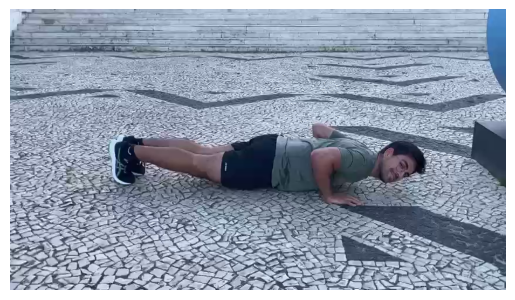

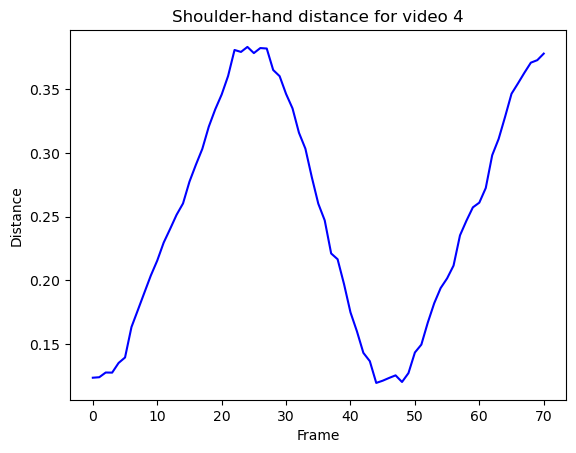

In [ ]:
print(cnn_results_binary)
print(angle_results_binary)
print(distance_results_binary)

# display image
plt.imshow(frame_up1)
plt.axis('off')
plt.show()

# display distance shoulder-hand
plt.plot(d_shoulder_hand_list, color='blue',label='shoulder-hand distance')

plt.title(f'Shoulder-hand distance for video {video_index}')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.show()
